# Initializing setup

In [26]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf

from tensorflow.keras.models import load_model

In [2]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return np.array(label['coords'])

In [3]:
def view_batch(batch=None, image_batch=None, coords_batch=None):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(15,8))
    for idx in range(8):
        if batch != None:
            image = batch[0][idx].copy()
            coords = batch[1][idx]
        else:
            image = image_batch[idx].copy()
            coords = coords_batch[idx]
        
        cv2.circle(image, tuple(np.multiply(coords[:2], [250,250]).astype(int)), 3, (255,0,0), -1)
        cv2.circle(image, tuple(np.multiply(coords[2:], [250,250]).astype(int)), 3, (0,255,0), -1)

        ax[int(idx/4)][idx%4].imshow(image)
        #ax[int(idx/4)][idx%4].plot(np.multiply(coords[0], [250]), np.multiply(coords[1], [250]), 'rx')
        #ax[int(idx/4)][idx%4].plot(np.multiply(coords[2], [250]), np.multiply(coords[3], [250]), 'gX')
    

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading data

In [5]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250, 250)))
val_images = val_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250, 250)))
test_images = test_images.map(lambda x: x/255)

In [6]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))
train_labels = train_labels.map(lambda x: tf.ensure_shape(x, (4)))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16], name='test_labels'))
test_labels = test_labels.map(lambda x: tf.ensure_shape(x, (4)))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16], name='val_labels'))
val_labels = val_labels.map(lambda x: tf.ensure_shape(x, (4)))

In [7]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(1250)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(210)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(210)
val = val.batch(8)
val = val.prefetch(4)

In [8]:
len(train)*8, len(test)*8, len(val)*8

(1200, 200, 200)

In [9]:
train_data = train.as_numpy_iterator()
test_data = test.as_numpy_iterator()
val_data = val.as_numpy_iterator()

# Visualizing data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

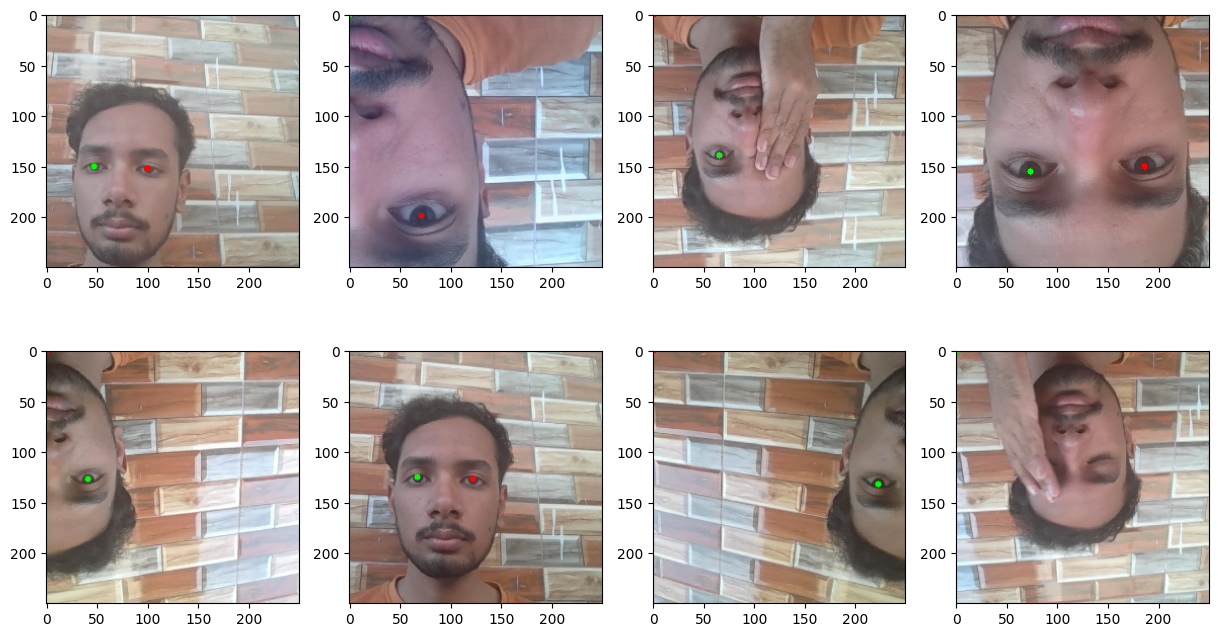

In [10]:
batch = train_data.next()
view_batch(batch)

# Building model

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [11]:
#ResNet152V2??
input_layer = Input(shape = (250, 250, 3))
backbone = ResNet152V2(include_top = False)(input_layer)

In [13]:
model = Sequential([
    Input(shape = (250, 250, 3)),
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.15),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

In [14]:
model.compile(opt, loss)

hist = model.fit(train, epochs = 20, validation_data=val)

model.save('model.keras')

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1732s 11s/step - loss: 2.1151 - val_loss: 0.0823
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1713s 11s/step - loss: 0.0404 - val_loss: 0.0578
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1728s 12s/step - loss: 0.0227 - val_loss: 0.0643
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1804s 12s/step - loss: 0.0153 - val_loss: 0.0579
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1823s 12s/step - loss: 0.0131 - val_loss: 0.0496
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5416s 36s/step - loss: 0.0083 - val_loss: 0.0528
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1518s 10s/step - loss: 0.0061 - val_loss: 0.0442
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1576s 10s/step - loss: 0.0065 - val_loss: 0.0534
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1598s 11s/step - loss: 0.0056 - val_loss: 0.0443
Epoch 10/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1607s 11s/step - loss: 0.0043 - val_loss: 0.0520
Epoch 11/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1579s 11s/step - loss: 0.0036 - val_loss: 0.0419
Epoch 12/20
150/150

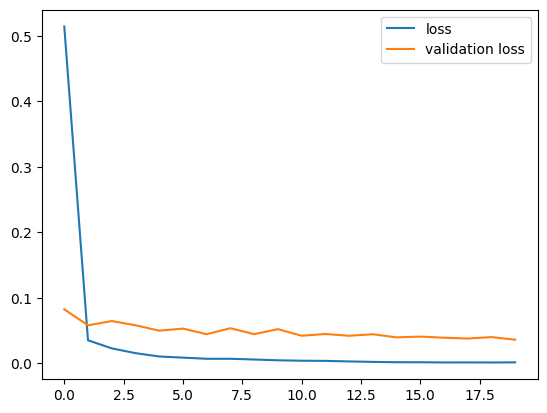

In [21]:
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend()

# Importing the saved model

In [32]:
model = load_model('model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

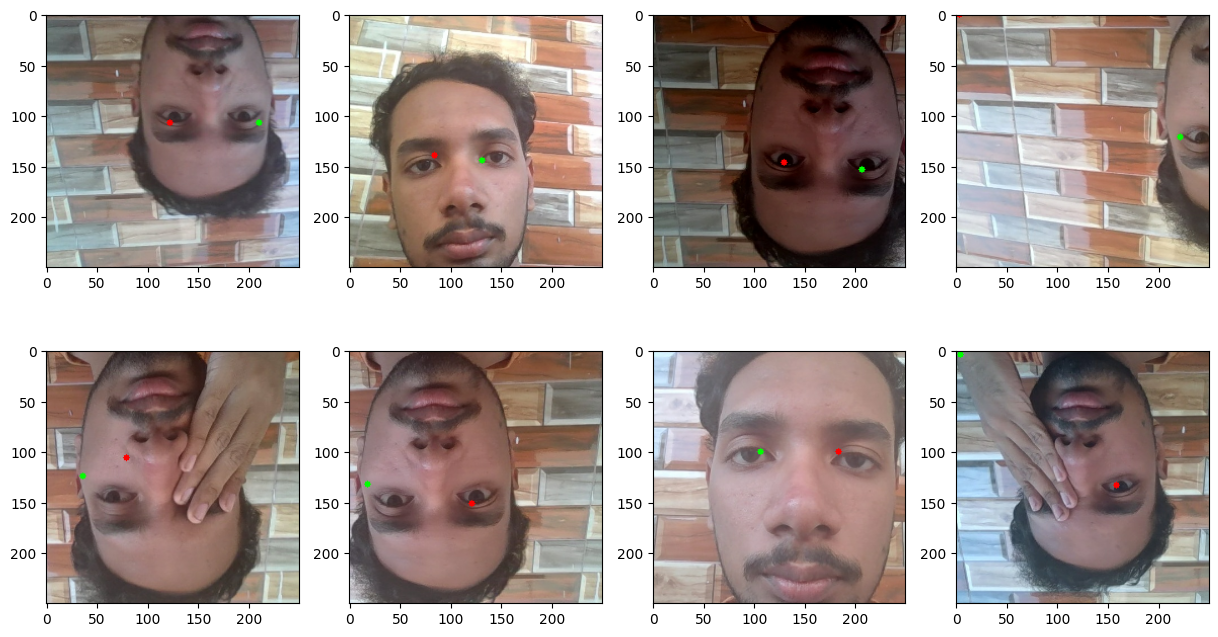

In [38]:
X, y = test_data.next()

pred = model.predict(X)

view_batch(None, X, pred)

In [25]:
'''class IrisTracker(Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def compile(self, opt, loss, **kwargs):
        super().compile(**kwargs)
        self.loss = loss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch
        
        with tf.GradientTape() as tape:
            coords = self.model(X, training=True)
            
            total_loss = self.loss(y, coords)

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {'total_loss': total_loss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch

        coords = self.model(X, training = False)

        total_loss = self.loss(y, coords)

        return {'total_loss': total_loss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)'''

In [24]:
'''tracker = IrisTracker(model=model)
tracker.compile(opt=opt, loss=loss)

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = tracker.fit(train, epochs=2, validation_data = val, callbacks = [tensorboard_callback])'''

"tracker = IrisTracker(model=model)\ntracker.compile(opt=opt, loss=loss)\n\nlogdir = 'logs'\ntensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)\n\nhist = tracker.fit(train, epochs=2, validation_data = val, callbacks = [tensorboard_callback])"